<a href="https://colab.research.google.com/github/ABR-2005/Secure-quantum-key-distribution-using-the-BB84-protocol/blob/main/BB84_protocol_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install qiskit


In [13]:
!pip uninstall -y qiskit


Found existing installation: qiskit 1.2.4
Uninstalling qiskit-1.2.4:
  Successfully uninstalled qiskit-1.2.4


In [14]:
!pip install qiskit[all]


  Using cached qiskit-1.2.4-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
Using cached qiskit-1.2.4-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.8 MB)


In [15]:
!pip install qiskit-aer


In [16]:
!pip install qiskit-aer  # Reinstalling qiskit-aer to ensure it's available
from qiskit_aer import Aer  # Importing Aer directly from qiskit_aer
from qiskit import QuantumCircuit
print(Aer.backends())

[AerSimulator('aer_simulator'), AerSimulator('aer_simulator_statevector'), AerSimulator('aer_simulator_density_matrix'), AerSimulator('aer_simulator_stabilizer'), AerSimulator('aer_simulator_matrix_product_state'), AerSimulator('aer_simulator_extended_stabilizer'), AerSimulator('aer_simulator_unitary'), AerSimulator('aer_simulator_superop'), QasmSimulator('qasm_simulator'), StatevectorSimulator('statevector_simulator'), UnitarySimulator('unitary_simulator')]


In [17]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import Aer  # Import Aer from qiskit_aer instead of qiskit
from qiskit.visualization import plot_histogram, plot_bloch_multivector

WITHOUT INTERCEPTION


┌───┐ ░ ┌───┐┌─┐
  q: ┤ H ├─░─┤ H ├┤M├
     └───┘ ░ └───┘└╥┘
c: 1/══════════════╩═
                   0

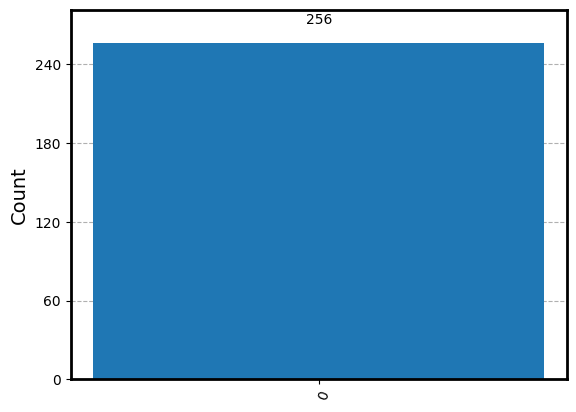

In [18]:
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
qc.barrier()
# Alice now sends the qubit to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)
# Draw and simulate circuit
display(qc.draw())
aer_sim = Aer.get_backend('aer_simulator')
# Pass the QuantumCircuit directly to run, not the assembled QasmQobj
job = aer_sim.run(qc,shots=256)
plot_histogram(job.result().get_counts())

WITH INTERCEPTION


┌───┐┌─┐ ░ ┌───┐┌─┐
  q: ┤ H ├┤M├─░─┤ H ├┤M├
     └───┘└╥┘ ░ └───┘└╥┘
c: 1/══════╩══════════╩═
           0          0

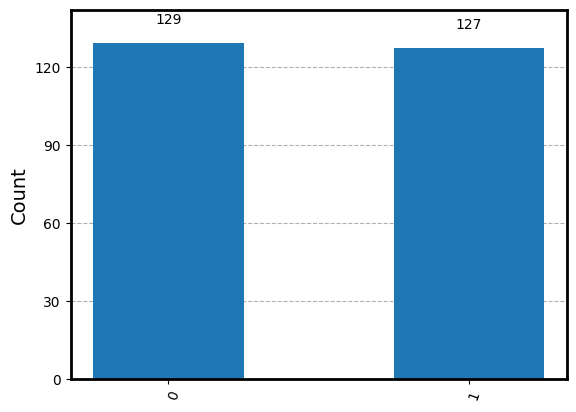

In [19]:
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
# Alice now sends the qubit to Bob
# but Eve intercepts and tries to read it
qc.measure(0, 0)
qc.barrier()
# Eve then passes this on to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
display(qc.draw())
aer_sim = Aer.get_backend('aer_simulator')
# Pass the QuantumCircuit directly to run, not the assembled QasmQobj
# The shots parameter should be passed as a keyword argument
job = aer_sim.run(qc, shots=256)
plot_histogram(job.result().get_counts())

WITHOUT INTERCEPTION


In [20]:
n = 100
## Step 1
# Alice generates bits.
alice_bits = np.random.randint(0,2,n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = np.random.randint(0,2,n)

# Function to compare the bits & bases generated by alice, and then 'encode' the message. Basically determines the state of the qubit/photon to send.
def encode_message(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: # Prepare qubit in Z-basis
            if bits[i] == 0:
                pass
            else:
                qc.x(0)
        else: # Prepare qubit in X-basis
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

# Alice computes the encoded message using the function defined above.
message = encode_message(alice_bits, alice_bases)

## Step 3

# Decide which basis to measure in:
bob_bases = np.random.randint(0,2,n)

# Function to decode the message sent by alice by comparing qubit/photon states with Bob's generated bases.
def measure_message(message, bases):
    backend = Aer.get_backend('aer_simulator')
    measurements = []
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0,0)
        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
        # Directly pass the QuantumCircuit to run, not the assembled QasmQobj
        # The change is here
        result = backend.run(message[q], shots=1, memory=True).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

# Decode the message according to his bases
bob_results = measure_message(message, bob_bases)

## Step 4

# Function to perform sifting i.e. disregard the bits for which Bob's & A;ice's bases didnot match.
def remove_garbage(a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            # If both used the same basis, add
            # this to the list of 'good' bits
            good_bits.append(bits[q])
    return good_bits

# Performing sifting for Alice's and Bob's bits.
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)

print("Alice's key after sifting (without interception)", alice_key)
print("Bob's key after sifting (without interception)  ", bob_key)

# # Step 5

num = 0
for i in range(0,len(bob_key)):
    if alice_key[i] == bob_key[i]:
        num = num + 1

matching_bits = (num/len(bob_key))*100
print(matching_bits,"% of the bits match.")

Alice's key after sifting (without interception) [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1]
Bob's key after sifting (without interception)   [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1]
100.0 % of the bits match.


WITH INTERCEPTION


In [21]:
## Step 1
alice_bits = np.random.randint(2, size=n)
## Step 2
alice_bases = np.random.randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = np.random.randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Step 3
bob_bases = np.random.randint(2, size=n)
bob_results = measure_message(message, bob_bases)
## Step 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)

print("Alice's key after sifting (with interception)", alice_key)
print("Bob's key after sifting (with interception)  ", bob_key)
# ## Step 5
# sample_size = 15
# bit_selection = np.random.randint(n, size=sample_size)
# bob_sample = sample_bits(bob_key, bit_selection)
# alice_sample = sample_bits(alice_key, bit_selection)

num = 0
for i in range(0,len(bob_key)):
    if alice_key[i] == bob_key[i]:
        num = num + 1

matching_bits = (num/len(bob_key))*100
print(matching_bits,"% of the bits match.")

Alice's key after sifting (with interception) [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
Bob's key after sifting (with interception)   [0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]
61.40350877192983 % of the bits match.


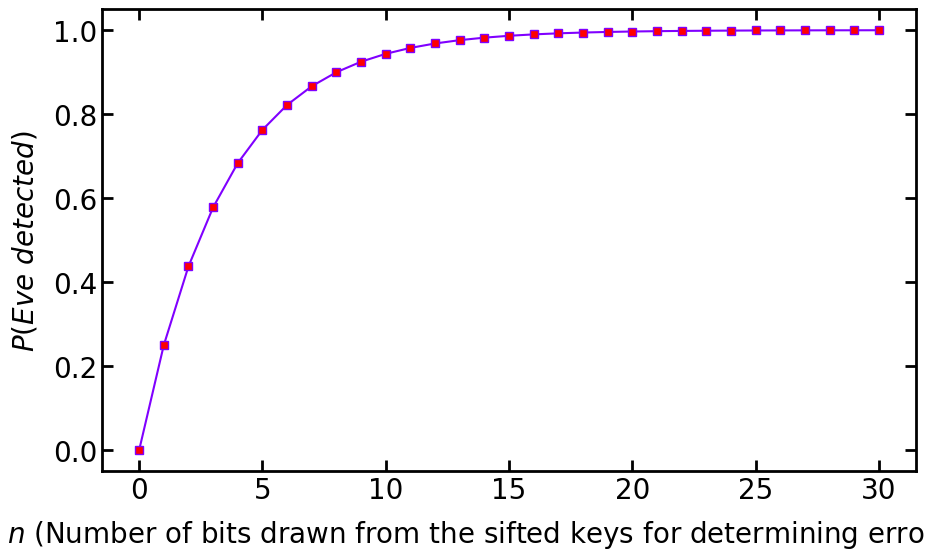

In [22]:
plt.rcParams['axes.linewidth'] = 2
mpl.rcParams['font.family'] = ['Georgia']

plt.figure(figsize=(10.5,6))
ax=plt.axes()
ax.set_title('')
ax.set_xlabel('$n$ (Number of bits drawn from the sifted keys for determining error rate)',fontsize = 18,labelpad=10)
ax.set_ylabel(r'$P(Eve\ detected)$',fontsize = 18,labelpad=10)
ax.xaxis.set_tick_params(which='major', size=8, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=8, width=2, direction='in', top='on')
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax. xaxis. label. set_size(20)
ax. yaxis. label. set_size(20)

n = 30
x = np.arange(n+1)
y = 1 - 0.75**x

ax.plot(x,y,color = plt.cm.rainbow(np.linspace(0, 1, 5))[0], marker = "s", markerfacecolor='r')